In [1]:
# Standard imports to manage dataframes
import zipfile
import pandas as pd
import numpy as np
### Augmentation
# import tensorflow as tf
from keras_preprocessing.image import img_to_array, array_to_img, load_img, ImageDataGenerator
### Visuals
import matplotlib.pyplot as plt
from skimage.io import imread
### Networks
# import keras
import tensorflow
import keras

In [2]:
# Image and data locs:
ziploc ="E:/School/UU/PATREC/CXR_project/"
imgloc = "E:/School/UU\PATREC/.darwin/datasets/v7-labs/covid-19-chest-x-ray-dataset/images/"
train_zf = zipfile.ZipFile(ziploc+'train_data.zip') 
val_zf = zipfile.ZipFile(ziploc+'val_data.zip') 
test_zf = zipfile.ZipFile(ziploc+'test_data.zip') 
train_df = pd.read_csv(train_zf.open('train_data.csv'))
val_df = pd.read_csv(val_zf.open('val_data.csv'))
test_df = pd.read_csv(test_zf.open('val_data.csv'))

Label decoding:

0: No pneumonia

1: bacterial pneumonia

2: Fungal pneumonia

3: Viral pneumonia

4: covid 

5: undefined pneumonia     maybe we should drop this but will add it for now

In [3]:
# Labeling data with key, by doing it in this order the viral 3 gets overwritten with 4 if there is covid which is what we want
def label(df):
    df["label"] = np.nan
    df.loc[df["type"] == "No Pneumonia", 'label'] = "A"
    df.loc[df["type"] == "Bacterial Pneumonia", 'label'] = "B"
    df.loc[df["type"] == "Fungal Pneumonia", 'label'] = "C"
    df.loc[df["type"] == "Viral Pneumonia", 'label'] = "D"
    df.loc[df["Covid"] == True, 'label'] = "E"
    df.loc[df["type"] == "Undefined Pneumonia", 'label'] = "F"
    return df
    

In [4]:
train = label(train_df)
val = label(val_df)
test = label(test_df)

In [5]:
# Verify that it went allright with previous distribution numbers, which it does
train.label.value_counts()

B    2252
A    1284
D    1159
E     416
C      18
F       8
Name: label, dtype: int64

For data augmentation we might want to consider dropping fungal and undefined which should lave us with 4 categories, but better represented and therefore data augmentation is probably easier

In [7]:
train.label.unique()

array(['B', 'A', 'C', 'F', 'D', 'E'], dtype=object)

In [8]:
def generate_train_data(df, filepath, batch_size, seed, shuffle):
#   Things that can be augmented
    datagenerator = ImageDataGenerator(rotation_range=10, # rotation
        width_shift_range=0.2, # horizontal shift
        height_shift_range=0.2, # vertical shift
        zoom_range=0.2, # zoom
        horizontal_flip=True, # horizontal flip
        brightness_range=[0.2,1.2]) # brightness)
#   Running augmentation on train dataset
    train_generator = datagenerator.flow_from_dataframe(
        dataframe = df,
        directory = filepath,
        x_col = "ogfilename",
        y_col = "label",
        class_mode = "categorical",
        batch_size = batch_size,
        seed = seed,
        shuffle = shuffle,
        target_size = (256,256), # Not sure if this holds aspect ratio
        keep_aspect_ratio = True,
        validate_filenames= True)

    return train_generator

In [9]:
train_generator = generate_train_data(train,imgloc, batch_size = 10, seed =4, shuffle = False)

Found 5137 validated image filenames belonging to 6 classes.


In [10]:
def plot_augmented_batch(train_generator, rows, cols):
    for X_batch, y_batch in train_generator:
        fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(15,15))
        for i in range(5):
            for k in range(6):
                image = next(train_generator)[0].astype('uint8')
                for j in image:
#                   changing size from (1, 256, 256, 3) to (256, 256, 3) for plotting the image
                    image = np.squeeze(j)
#                   plot raw pixel data
                    ax[i,k].imshow(j)
                    ax[i,k].axis('off')
        break

In [11]:
# runs easier with just the one image
augment_image =  generate_train_data(train[:1],imgloc, batch_size = 10, seed =4, shuffle = False)

Found 1 validated image filenames belonging to 1 classes.


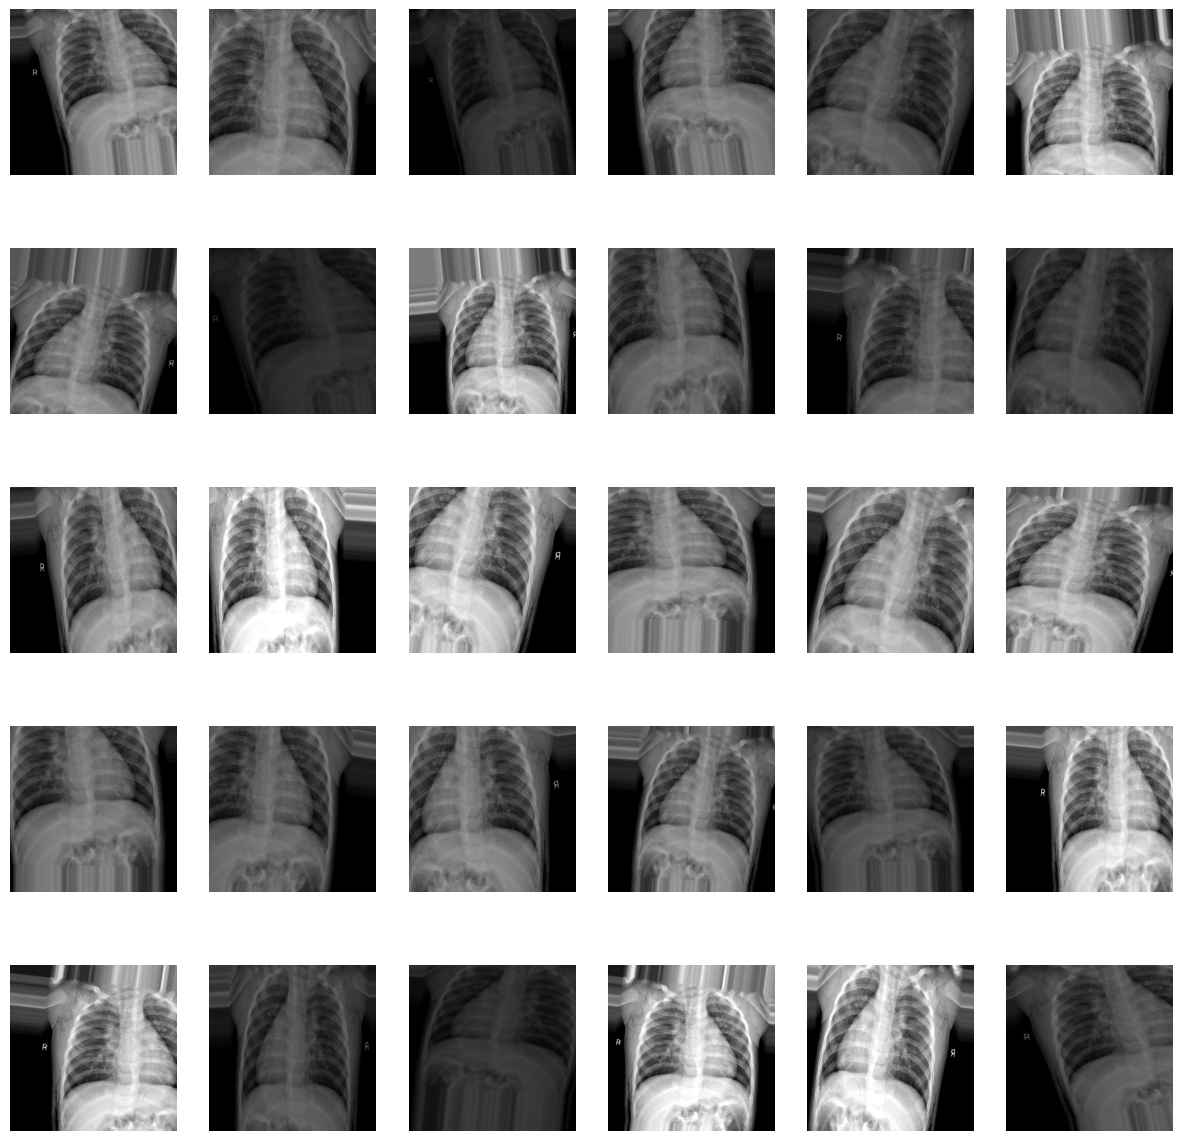

In [12]:
plot_augmented_batch(augment_image, 5,6)

In [14]:
valid_generator = generate_train_data(val, imgloc, batch_size = 10, seed =4, shuffle = True)

Found 643 validated image filenames belonging to 6 classes.


In [15]:
def generate_test_data(df, filepath, batch_size, seed):
#     Just rescale here for test
    datagenerator =  ImageDataGenerator(rescale= 1/255)
    test_generator = datagenerator.flow_from_dataframe(
        dataframe = df,
        directory = filepath,
        x_col = "ogfilename",
        y_col = None,
        class_mode = None,
        batch_size = batch_size,
        seed = seed,
        shuffle = False,
        target_size = (256,256), # Not sure if this holds aspect ratio
        keep_aspect_ratio = True,
        validate_filenames= True)
    return test_generator

In [16]:
test_generator = generate_test_data(test, imgloc, batch_size = 10, seed =4)

Found 646 validated image filenames.


In [17]:
# GPU check and version
print(tensorflow.config.list_physical_devices("GPU"))

print("________________________________________________")

print(tensorflow.test.is_gpu_available(cuda_only = False, min_cuda_compute_capability = None))

print("________________________________________________")

print("Current tensorflow version == {}".format(tensorflow. __version__))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
________________________________________________
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True
________________________________________________
Current tensorflow version == 2.10.0


In [18]:
model2 = keras.Sequential()
model2.add(keras.layers.Conv2D(filters=32, kernel_size=(3, 3),
activation="relu", input_shape=(256, 256, 3))) # input size
model2.add(keras.layers.Conv2D(filters=64, kernel_size=(3, 3),
activation="relu"))
model2.add(keras.layers.MaxPool2D(pool_size=(2, 2)))
model2.add(keras.layers.Dropout(rate=0.25))
model2.add(keras.layers.Flatten())
model2.add(keras.layers.Dense(128, activation="relu"))
model2.add(keras.layers.Dropout(rate=0.5))
model2.add(keras.layers.Dense(6, activation="sigmoid")) # Number of categories
model2.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adadelta(learning_rate=1),
metrics='accuracy')

In [19]:
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 252, 252, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 64)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 126, 126, 64)      0         
                                                                 
 flatten (Flatten)           (None, 1016064)           0         
                                                                 
 dense (Dense)               (None, 128)               130056320 
                                                        

In [20]:
# y_train = keras.utils.to_categorical(train.label, 6)
# y_train

In [21]:
STEP_SIZE_TRAIN=train_generator.n//10
STEP_SIZE_VALID=valid_generator.n//10
STEP_SIZE_TEST=test_generator.n//10
history = model2.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=10
)

Epoch 1/10


C:\Users\jensr\AppData\Local\Temp\ipykernel_10540\557235595.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model2.fit_generator(generator=train_generator,


513/513 [==============================] - 112s 217ms/step - loss: 147.7585 - accuracy: 0.4761 - val_loss: 1.1124 - val_accuracy: 0.5625
Epoch 2/10
513/513 [==============================] - 113s 220ms/step - loss: 1.6045 - accuracy: 0.5572 - val_loss: 1.0315 - val_accuracy: 0.6078
Epoch 3/10
513/513 [==============================] - 117s 227ms/step - loss: 2.1165 - accuracy: 0.5693 - val_loss: 0.9892 - val_accuracy: 0.6031
Epoch 4/10
513/513 [==============================] - 122s 237ms/step - loss: 3.2898 - accuracy: 0.5713 - val_loss: 0.9793 - val_accuracy: 0.6562
Epoch 5/10
513/513 [==============================] - 122s 238ms/step - loss: 2.1056 - accuracy: 0.5875 - val_loss: 1.0792 - val_accuracy: 0.5844
Epoch 6/10
513/513 [==============================] - 126s 245ms/step - loss: 2.1840 - accuracy: 0.5871 - val_loss: 0.9733 - val_accuracy: 0.6562
Epoch 7/10
513/513 [==============================] - 128s 249ms/step - loss: 2.6479 - accuracy: 0.5916 - val_loss: 1.0904 - val_accu

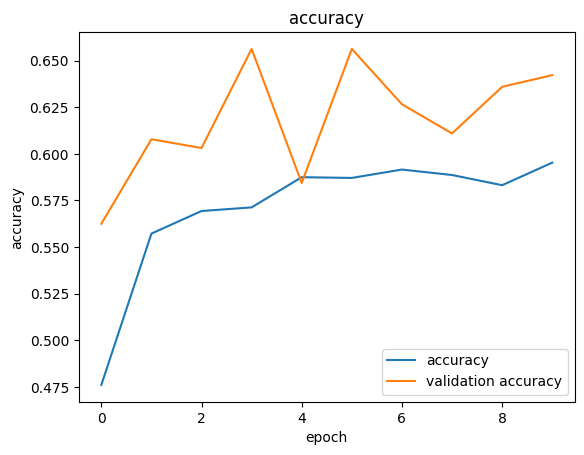

In [22]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'validation accuracy'], loc='lower right')
plt.title("accuracy")
plt.show()

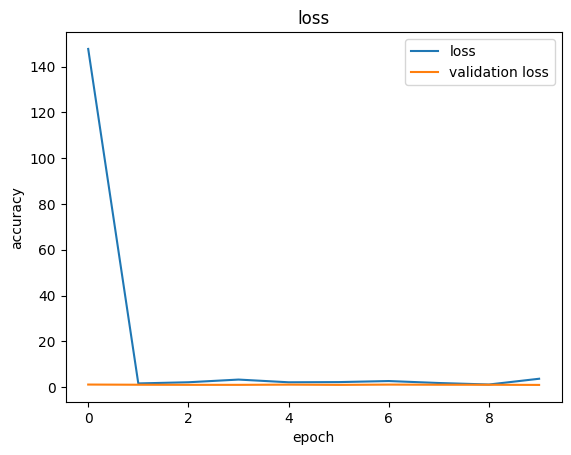

In [23]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['loss', 'validation loss'], loc='upper right')
plt.title("loss")
plt.show()